In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 20
pd.options.display.max_rows = 20

## Project Outline

Interest Rate Data
- 1Y & 10Y

Economic Data
- Unemployment rate monthly
- US CPI monthly
- US PCE monthly
- US GDP monthly
- Debt / GDP
- CPI Swaps 1Y, 2Y, 5Y, 10Y

Tempdisagg
- https://journal.r-project.org/archive/2013-2/sax-steiner.pdf

Frame Types
- Monthly release date (easy!)
    - Create an average for the rates, and weight the rate toward the release
- Imputed daily release date (currently working on)
- Classification actual release date (Joseph's idea)

## Step 0: Load in Data

In [251]:
# Loading in the file

fh = '/Users/henrycosentino/Desktop/Python/Projects/Yield Curve/key_rate_model_datapull.xlsx'
fh_2 = '/Users/henrycosentino/Desktop/Python/Projects/Yield Curve/key_rate_model_datapull2.xlsx'
df = pd.read_excel(fh_2, sheet_name='Values', parse_dates=True)
df.head()

,M2 Release Date Day,Money Supply (M2),Money Supply (M2).1,U-3 UE Release Date Day,U-3 Unemployment Rate SA Monthly,U-3 Unemployment Rate SA Monthly.1,NFP Release Date Day,NFP SA Monthly,NFP SA Monthly.1,CPI Release Date Day,...,MOVE Index Daily,MOVE Index Daily.1,1YR Yield Daily,1YR Yield Daily.1,10YR Yield Daily,10YR Yield Daily.1,Fed Funds Effective Rate Daily,Fed Funds Effective Rate Daily.1,US Treasury Total Debt Outstanding Debt,US Treasury Total Debt Outstanding Debt.1
0,M2 Index,M2 Index,PX_LAST,USURTOT Index,USURTOT Index,PX_LAST,NFP T Index,NFP T Index,PX_LAST,CPI INDX Index,...,MOVE Index,PX_LAST,USGG12M Index,PX_LAST,USGG10YR Index,PX_LAST,FEDL01 Index,PX_LAST,PUBLDEBT Index,PX_LAST
1,ECO_RELEASE_DT_LIST,2024-08-31 00:00:00,1999-12-31 00:00:00,ECO_RELEASE_DT_LIST,2024-08-31 00:00:00,1999-12-31 00:00:00,ECO_RELEASE_DT_LIST,2024-08-31 00:00:00,1999-12-31 00:00:00,ECO_RELEASE_DT_LIST,...,2024-08-31 00:00:00,1999-12-31 00:00:00,2024-08-31 00:00:00,1999-12-31 00:00:00,2024-08-31 00:00:00,1999-12-31 00:00:00,2024-08-31 00:00:00,1999-12-31 00:00:00,2024-08-31 00:00:00,1999-12-31 00:00:00
2,Actual Release Date,Frequency,D,Actual Release Date,Frequency,M,Actual Release Date,Frequency,M,Actual Release Date,...,Frequency,D,Frequency,D,Frequency,D,Frequency,D,Frequency,D
3,1999-12-29 00:00:00,2024-08-31 00:00:00,21141.2,19991203,2024-08-31 00:00:00,4.2,19991203,2024-08-31 00:00:00,158851,19991214,...,2024-08-30 00:00:00,107.77,2024-08-30 00:00:00,4.38,2024-08-30 00:00:00,3.91,2024-08-30 00:00:00,5.33,2024-08-30 00:00:00,35256.06
4,2000-01-25 00:00:00,2024-07-31 00:00:00,21039.4,20000107,2024-07-31 00:00:00,4.3,20000107,2024-07-31 00:00:00,158692,20000114,...,2024-08-29 00:00:00,106.7,2024-08-29 00:00:00,4.38,2024-08-29 00:00:00,3.87,2024-08-29 00:00:00,5.33,2024-08-29 00:00:00,35279.78


In [252]:
# Minor data frame cleanup

df.drop(df.index[0:3], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,M2 Release Date Day,Money Supply (M2),Money Supply (M2).1,U-3 UE Release Date Day,U-3 Unemployment Rate SA Monthly,U-3 Unemployment Rate SA Monthly.1,NFP Release Date Day,NFP SA Monthly,NFP SA Monthly.1,CPI Release Date Day,...,MOVE Index Daily,MOVE Index Daily.1,1YR Yield Daily,1YR Yield Daily.1,10YR Yield Daily,10YR Yield Daily.1,Fed Funds Effective Rate Daily,Fed Funds Effective Rate Daily.1,US Treasury Total Debt Outstanding Debt,US Treasury Total Debt Outstanding Debt.1
0,1999-12-29 00:00:00,2024-08-31 00:00:00,21141.2,19991203,2024-08-31 00:00:00,4.2,19991203,2024-08-31 00:00:00,158851,19991214,...,2024-08-30 00:00:00,107.77,2024-08-30 00:00:00,4.38,2024-08-30 00:00:00,3.91,2024-08-30 00:00:00,5.33,2024-08-30 00:00:00,35256.06
1,2000-01-25 00:00:00,2024-07-31 00:00:00,21039.4,20000107,2024-07-31 00:00:00,4.3,20000107,2024-07-31 00:00:00,158692,20000114,...,2024-08-29 00:00:00,106.7,2024-08-29 00:00:00,4.38,2024-08-29 00:00:00,3.87,2024-08-29 00:00:00,5.33,2024-08-29 00:00:00,35279.78
2,2000-02-22 00:00:00,2024-06-30 00:00:00,21020.1,20000204,2024-06-30 00:00:00,4.1,20000204,2024-06-30 00:00:00,158548,20000218,...,2024-08-28 00:00:00,108.76,2024-08-28 00:00:00,4.36,2024-08-28 00:00:00,3.84,2024-08-28 00:00:00,5.33,2024-08-28 00:00:00,35269.7
3,2000-03-28 00:00:00,2024-05-31 00:00:00,20959.4,20000303,2024-05-31 00:00:00,4,20000303,2024-05-31 00:00:00,158430,20000317,...,2024-08-27 00:00:00,109.22,2024-08-27 00:00:00,4.34,2024-08-27 00:00:00,3.83,2024-08-27 00:00:00,5.33,2024-08-27 00:00:00,35289.49
4,2000-04-25 00:00:00,2024-04-30 00:00:00,20881.1,20000407,2024-04-30 00:00:00,3.9,20000407,2024-04-30 00:00:00,158214,20000414,...,2024-08-26 00:00:00,106.66,2024-08-26 00:00:00,4.38,2024-08-26 00:00:00,3.82,2024-08-26 00:00:00,5.33,2024-08-26 00:00:00,35225.18


In [253]:
# Renaming the columns

new_columns_ls = []
for col in df.columns:
    if col.endswith("1"):
        x = col.find(".1")
        col = col[0:x]
        col = col.lower()
        new_columns_ls.append(col)
    elif col.endswith("Release Date Day"):
        z = col.find("Release")
        col = col[0:z]
        col = f"{col.lower()}actual release date"
        new_columns_ls.append(col)
    else:
        col = f"{col.lower()} date"
        new_columns_ls.append(col)

df.columns = new_columns_ls
df.head()

,m2 actual release date,money supply (m2) date,money supply (m2),u-3 ue actual release date,u-3 unemployment rate sa monthly date,u-3 unemployment rate sa monthly,nfp actual release date,nfp sa monthly date,nfp sa monthly,cpi actual release date,...,move index daily date,move index daily,1yr yield daily date,1yr yield daily,10yr yield daily date,10yr yield daily,fed funds effective rate daily date,fed funds effective rate daily,us treasury total debt outstanding debt date,us treasury total debt outstanding debt
0,1999-12-29 00:00:00,2024-08-31 00:00:00,21141.2,19991203,2024-08-31 00:00:00,4.2,19991203,2024-08-31 00:00:00,158851,19991214,...,2024-08-30 00:00:00,107.77,2024-08-30 00:00:00,4.38,2024-08-30 00:00:00,3.91,2024-08-30 00:00:00,5.33,2024-08-30 00:00:00,35256.06
1,2000-01-25 00:00:00,2024-07-31 00:00:00,21039.4,20000107,2024-07-31 00:00:00,4.3,20000107,2024-07-31 00:00:00,158692,20000114,...,2024-08-29 00:00:00,106.7,2024-08-29 00:00:00,4.38,2024-08-29 00:00:00,3.87,2024-08-29 00:00:00,5.33,2024-08-29 00:00:00,35279.78
2,2000-02-22 00:00:00,2024-06-30 00:00:00,21020.1,20000204,2024-06-30 00:00:00,4.1,20000204,2024-06-30 00:00:00,158548,20000218,...,2024-08-28 00:00:00,108.76,2024-08-28 00:00:00,4.36,2024-08-28 00:00:00,3.84,2024-08-28 00:00:00,5.33,2024-08-28 00:00:00,35269.7
3,2000-03-28 00:00:00,2024-05-31 00:00:00,20959.4,20000303,2024-05-31 00:00:00,4,20000303,2024-05-31 00:00:00,158430,20000317,...,2024-08-27 00:00:00,109.22,2024-08-27 00:00:00,4.34,2024-08-27 00:00:00,3.83,2024-08-27 00:00:00,5.33,2024-08-27 00:00:00,35289.49
4,2000-04-25 00:00:00,2024-04-30 00:00:00,20881.1,20000407,2024-04-30 00:00:00,3.9,20000407,2024-04-30 00:00:00,158214,20000414,...,2024-08-26 00:00:00,106.66,2024-08-26 00:00:00,4.38,2024-08-26 00:00:00,3.82,2024-08-26 00:00:00,5.33,2024-08-26 00:00:00,35225.18


In [254]:
# Converting all date columns to datetime

for col in df.columns:
    if 'date' in col:
        df[col] = df[col].apply(lambda dt: pd.to_datetime(dt, format='%Y%m%d'))

In [255]:
# Grouping data frames by release frequency and relevance

ls_macro_d = [
       'cpi 1yr swaps daily date', 'cpi 1yr swaps daily',
       'cpi 2yr swaps daily date', 'cpi 2yr swaps daily',
       'cpi 5yr swaps daily date', 'cpi 5yr swaps daily',
       'cpi 10yr swaps daily date', 'cpi 10yr swaps daily',
       'move index daily date', 'move index daily', 
       '1yr yield daily date', '1yr yield daily', 
       '10yr yield daily date', '10yr yield daily',
       'fed funds effective rate daily date', 'fed funds effective rate daily',
       'us treasury total debt outstanding debt date', 'us treasury total debt outstanding debt']
ls_macro_m = [
       'm2 actual release date', 'money supply (m2) date', 'money supply (m2)',
       'u-3 ue actual release date', 'u-3 unemployment rate sa monthly date', 'u-3 unemployment rate sa monthly', 
       'nfp actual release date', 'nfp sa monthly date', 'nfp sa monthly',
       'cpi actual release date', 'cpi sa index monthly date', 'cpi sa index monthly', 
       'pce actual release date', 'pce sa index monthly date', 'pce sa index monthly']
ls_macro_q = [
       'real gdp actual release date', 'real gdp us index quarterly date', 'real gdp us index quarterly', 
       'nominal gdp actual release date', 'nominal gdp us index quarterly date', 'nominal gdp us index quarterly']

df_macro_d = df[ls_macro_d]
df_macro_m = df[ls_macro_m]
df_macro_q = df[ls_macro_q]

## Step 1: Clean and Impute Monthly Macro Data

In [256]:
# Cleaning and preparing the monthly macro data frame for manipulation

df_macro_m = df_macro_m[0:298]
for col in df_macro_m:
    if col.endswith("actual release date"):
        df_macro_m[col] = df_macro_m[col][::-1].reset_index(drop=True)

In [257]:
# Flipping all data, and dropping last row, since it is unecessary

df_macro_m_c = df_macro_m.copy()
df_macro_m_c = df_macro_m_c[::-1]
df_macro_m_c = df_macro_m_c.dropna().reset_index(drop=True)
df_macro_m_c

,m2 actual release date,money supply (m2) date,money supply (m2),u-3 ue actual release date,u-3 unemployment rate sa monthly date,u-3 unemployment rate sa monthly,nfp actual release date,nfp sa monthly date,nfp sa monthly,cpi actual release date,cpi sa index monthly date,cpi sa index monthly,pce actual release date,pce sa index monthly date,pce sa index monthly
0,2000-01-25,1999-12-31,4639.3,2000-01-07,1999-12-31,4,2000-01-07,1999-12-31,130781,2000-01-14,1999-12-31,168.8,2000-01-31,1999-12-31,72.763
1,2000-02-22,2000-01-31,4667.6,2000-02-04,2000-01-31,4,2000-02-04,2000-01-31,131009,2000-02-18,2000-01-31,169.3,2000-02-28,2000-01-31,72.961
2,2000-03-28,2000-02-29,4680.9,2000-03-03,2000-02-29,4.1,2000-03-03,2000-02-29,131120,2000-03-17,2000-02-29,170,2000-03-31,2000-02-29,73.191
3,2000-04-25,2000-03-31,4711.7,2000-04-07,2000-03-31,4,2000-04-07,2000-03-31,131604,2000-04-14,2000-03-31,171,2000-04-28,2000-03-31,73.505
4,2000-05-23,2000-04-30,4767.8,2000-05-05,2000-04-30,3.8,2000-05-05,2000-04-30,131883,2000-05-16,2000-04-30,170.9,2000-05-26,2000-04-30,73.444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2024-05-28,2024-04-30,20881.1,2024-05-03,2024-04-30,3.9,2024-05-03,2024-04-30,158214,2024-05-15,2024-04-30,313.207,2024-05-31,2024-04-30,123.234
293,2024-06-25,2024-05-31,20959.4,2024-06-07,2024-05-31,4,2024-06-07,2024-05-31,158430,2024-06-12,2024-05-31,313.225,2024-06-28,2024-05-31,123.224
294,2024-07-23,2024-06-30,21020.1,2024-07-05,2024-06-30,4.1,2024-07-05,2024-06-30,158548,2024-07-11,2024-06-30,313.049,2024-07-26,2024-06-30,123.369
295,2024-08-27,2024-07-31,21039.4,2024-08-02,2024-07-31,4.3,2024-08-02,2024-07-31,158692,2024-08-14,2024-07-31,313.534,2024-08-30,2024-07-31,123.558


In [258]:
# Imputing functions for M2, NFP, CPI, & PCE for monthly data frame

# This function returns the daily percentage change for a given economic variable
def daily_pct_chg(frame, asset_col, date_col):

    percent_chg = ((frame[asset_col].dropna() / frame[asset_col].dropna().shift(1) - 1)).dropna().reset_index(drop=True)

    month_length = frame[date_col].dropna() - frame[date_col].dropna().shift(1) # Finding difference between releases
    month_length = month_length.dt.days.dropna().astype(int) # Converting datetime to int

    daily_pct_chg = (1 + pd.array(percent_chg))**(1 / pd.array(month_length)) # Calculating the daily compound percent change for the month
    return daily_pct_chg

# This function imputes missing data using compounding
def compound_imputer(frame, column, cpi_daily_chg):
    
    daily_compound_ls = []
    non_na_count = 0

    for row in frame[column]:
        if pd.notna(row):
            daily_compound_ls.append(row)
            non_na_count += 1
        else:
            x = non_na_count - 1
            last_value = daily_compound_ls[len(daily_compound_ls) - 1]
            imputed_value = last_value * cpi_daily_chg[x]  # Compute the imputed value
            daily_compound_ls.append(imputed_value)

    return daily_compound_ls

m2_daily_chg = daily_pct_chg(df_macro_m_c, 'money supply (m2)', 'm2 actual release date')
nfp_daily_chg = daily_pct_chg(df_macro_m_c, 'nfp sa monthly', 'nfp actual release date')
cpi_daily_chg = daily_pct_chg(df_macro_m_c, 'cpi sa index monthly', 'cpi actual release date')
pce_daily_chg = daily_pct_chg(df_macro_m_c, 'pce sa index monthly', 'pce actual release date')

/Users/henrycosentino/anaconda3/lib/python3.12/site-packages/pandas/core/roperator.py:27: RuntimeWarning: divide by zero encountered in divide
  return right / left


In [259]:
# M2 Imputation


# Create a date range for M2
m2_start_date = '2000-01-25'
m2_end_date = '2024-09-24'

date_range = pd.date_range(start=m2_start_date, end=m2_end_date)
date_range = pd.DataFrame(date_range, columns=['date'])


# Creating a unique M2 data frame
m2_df = df_macro_m_c[['m2 actual release date', 'money supply (m2)']]
m2_df = m2_df.rename(columns={'m2 actual release date':'date'})
m2_df = pd.merge(date_range, m2_df, how='left', on='date')
m2_df = m2_df.reset_index(drop=True)


# Imputing values and adding to M2 data frame
daily_m2 = compound_imputer(m2_df, 'money supply (m2)', m2_daily_chg)
m2_df['m2 daily'] = daily_m2
m2_df['m2 daily pct chg'] = m2_df['m2 daily'] / m2_df['m2 daily'].shift(1) - 1
m2_df['m2 90 day rolling avg'] = (1 + m2_df['m2 daily pct chg']).rolling(window=90).apply(lambda x: x.prod()) - 1
m2_df = m2_df[['date','m2 daily pct chg','m2 90 day rolling avg']]
m2_df

,date,m2 daily pct chg,m2 90 day rolling avg
0,2000-01-25,NaN,NaN
1,2000-01-26,0.000217,NaN
2,2000-01-27,0.000217,NaN
3,2000-01-28,0.000217,NaN
4,2000-01-29,0.000217,NaN
...,...,...,...
9005,2024-09-20,0.000172,0.008383
9006,2024-09-21,0.000172,0.008422
9007,2024-09-22,0.000172,0.008461
9008,2024-09-23,0.000172,0.008500


In [260]:
# NFP Imputation


# Create a date range for NFP
nfp_start_date = '2000-01-07'
nfp_end_date = '2024-09-06'

date_range = pd.date_range(start=nfp_start_date, end=nfp_end_date)
date_range = pd.DataFrame(date_range, columns=['date'])


# Creating a unique NFP data frame
nfp_df = df_macro_m_c[['nfp actual release date', 'nfp sa monthly']]
nfp_df = nfp_df.rename(columns={'nfp actual release date':'date'})
nfp_df = pd.merge(date_range, nfp_df, how='left', on='date')
nfp_df = nfp_df.reset_index(drop=True)


# Imputing values and adding to NFP data frame
daily_nfp = compound_imputer(nfp_df, 'nfp sa monthly', nfp_daily_chg)
nfp_df['nfp daily'] = daily_nfp
nfp_df['nfp daily pct chg'] = nfp_df['nfp daily'] / nfp_df['nfp daily'].shift(1) - 1
nfp_df['nfp 90 day rolling avg'] = (1 + nfp_df['nfp daily pct chg']).rolling(window=90).apply(lambda x: x.prod()) - 1
nfp_df = nfp_df[['date','nfp daily pct chg','nfp 90 day rolling avg']]
nfp_df

,date,nfp daily pct chg,nfp 90 day rolling avg
0,2000-01-07,NaN,NaN
1,2000-01-08,0.000062,NaN
2,2000-01-09,0.000062,NaN
3,2000-01-10,0.000062,NaN
4,2000-01-11,0.000062,NaN
...,...,...,...
9005,2024-09-02,0.000029,0.002660
9006,2024-09-03,0.000029,0.002649
9007,2024-09-04,0.000029,0.002639
9008,2024-09-05,0.000029,0.002629


In [261]:
# CPI Imputation


# Create a date range for CPI
cpi_start_date = '2000-01-14'
cpi_end_date = '2024-09-11'

date_range = pd.date_range(start=cpi_start_date, end=cpi_end_date)
date_range = pd.DataFrame(date_range, columns=['date'])


# Creating a unique CPI data frame
cpi_df = df_macro_m_c[['cpi actual release date', 'cpi sa index monthly']]
cpi_df = cpi_df.rename(columns={'cpi actual release date':'date'})
cpi_df = pd.merge(date_range, cpi_df, how='left', on='date')
cpi_df = cpi_df.reset_index(drop=True)


# Imputing values and adding to CPI data frame
daily_cpi = compound_imputer(cpi_df, 'cpi sa index monthly', cpi_daily_chg)
cpi_df['cpi daily'] = daily_cpi
cpi_df['cpi daily pct chg'] = cpi_df['cpi daily'] / cpi_df['cpi daily'].shift(1) - 1
cpi_df['cpi 90 day rolling avg'] = (1 + cpi_df['cpi daily pct chg']).rolling(window=90).apply(lambda x: x.prod()) - 1
cpi_df = cpi_df[['date','cpi daily pct chg','cpi 90 day rolling avg']]
cpi_df

,date,cpi daily pct chg,cpi 90 day rolling avg
0,2000-01-14,NaN,NaN
1,2000-01-15,0.000085,NaN
2,2000-01-16,0.000085,NaN
3,2000-01-17,0.000085,NaN
4,2000-01-18,0.000085,NaN
...,...,...,...
9003,2024-09-07,0.000067,0.002599
9004,2024-09-08,0.000067,0.002664
9005,2024-09-09,0.000067,0.002729
9006,2024-09-10,0.000067,0.002794


In [262]:
# PCE Imputation


# Create a date range for PCE
pce_start_date = '2000-01-31'
pce_end_date = '2024-09-27'

date_range = pd.date_range(start=pce_start_date, end=pce_end_date)
date_range = pd.DataFrame(date_range, columns=['date'])


# Creating a unique PCE data frame
pce_df = df_macro_m_c[['pce actual release date', 'pce sa index monthly']]
pce_df = pce_df.rename(columns={'pce actual release date':'date'})
pce_df = pd.merge(date_range, pce_df, how='left', on='date')
pce_df = pce_df.reset_index(drop=True)


# Imputing values and adding to PCE data frame
daily_pce = compound_imputer(pce_df, 'pce sa index monthly', pce_daily_chg)
pce_df['pce daily'] = daily_pce
pce_df['pce daily pct chg'] = pce_df['pce daily'] / pce_df['pce daily'].shift(1) - 1
pce_df['pce 90 day rolling avg'] = (1 + pce_df['pce daily pct chg']).rolling(window=90).apply(lambda x: x.prod()) - 1
pce_df = pce_df[['date','pce daily pct chg','pce 90 day rolling avg']]
pce_df

,date,pce daily pct chg,pce 90 day rolling avg
0,2000-01-31,NaN,NaN
1,2000-02-01,0.000097,NaN
2,2000-02-02,0.000097,NaN
3,2000-02-03,0.000097,NaN
4,2000-02-04,0.000097,NaN
...,...,...,...
9003,2024-09-23,0.000032,0.003481
9004,2024-09-24,0.000032,0.003516
9005,2024-09-25,0.000032,0.003552
9006,2024-09-26,0.000032,0.003587


In [263]:
# U3 Imputation


# Create a date range for U3
u3_start_date = '2000-01-07'
u3_end_date = '2024-09-06'

date_range = pd.date_range(start=u3_start_date, end=u3_end_date)
date_range = pd.DataFrame(date_range, columns=['date'])


# Creating a unique U3 data frame
u3_df = df_macro_m_c[['u-3 ue actual release date', 'u-3 unemployment rate sa monthly']]
u3_df = u3_df.rename(columns={'u-3 ue actual release date':'date'})
u3_df = pd.merge(date_range, u3_df, how='left', on='date')
u3_df = u3_df.reset_index(drop=True)


# Imputing U3 using Linear Interpolation
u3_df['u-3 unemployment rate sa monthly'] = pd.to_numeric(u3_df['u-3 unemployment rate sa monthly'], errors='coerce')
u3_df['u3 daily'] = u3_df['u-3 unemployment rate sa monthly'].interpolate(method='linear')
u3_df = u3_df[['date', 'u3 daily']]
u3_df

,date,u3 daily
0,2000-01-07,4.000000
1,2000-01-08,4.000000
2,2000-01-09,4.000000
3,2000-01-10,4.000000
4,2000-01-11,4.000000
...,...,...
9005,2024-09-02,4.211429
9006,2024-09-03,4.208571
9007,2024-09-04,4.205714
9008,2024-09-05,4.202857


## Step 2: Clean and Impute Quarterly Macro Data

In [264]:
# Real GDP Growth
# Nominal GDP to Total Debt Outstanding

df_macro_q_c = df_macro_q.copy()
df_macro_q_c = df_macro_q_c[:99]
df_macro_q_c = df_macro_q_c[::-1].reset_index(drop=True)
df_macro_q_c

,real gdp actual release date,real gdp us index quarterly date,real gdp us index quarterly,nominal gdp actual release date,nominal gdp us index quarterly date,nominal gdp us index quarterly
0,2000-01-28,1999-12-31,13828,2000-01-28,1999-12-31,9900.17
1,2000-04-27,2000-03-31,13878.1,2000-04-27,2000-03-31,10002.18
2,2000-07-28,2000-06-30,14130.9,2000-07-28,2000-06-30,10247.72
3,2000-10-27,2000-09-29,14145.3,2000-10-27,2000-09-29,10318.17
4,2001-01-31,2000-12-29,14229.8,2001-01-31,2000-12-29,10435.74
...,...,...,...,...,...,...
94,2023-07-27,2023-06-30,22539.4,2023-07-27,2023-06-30,27453.82
95,2023-10-26,2023-09-29,22780.9,2023-10-26,2023-09-29,27967.7
96,2024-01-25,2023-12-29,22960.6,2024-01-25,2023-12-29,28296.97
97,2024-04-25,2024-03-29,23053.5,2024-04-25,2024-03-29,28624.07


In [265]:
# Real GDP Imputation

# Gathering daily percent change data
real_gdp_daily_chg = daily_pct_chg(df_macro_q_c, 'real gdp us index quarterly', 'real gdp actual release date')

# Create a date range for Real GDP 
gdp_start_date = '2000-01-28'
gdp_end_date = '2024-07-25'

date_range = pd.date_range(start=gdp_start_date, end=gdp_end_date)
date_range = pd.DataFrame(date_range, columns=['date'])


# Creating a unique Real GDP data frame
real_gdp_df = df_macro_q_c[['real gdp actual release date', 'real gdp us index quarterly']]
real_gdp_df = real_gdp_df.rename(columns={'real gdp actual release date':'date'})
real_gdp_df = pd.merge(date_range, real_gdp_df, how='left', on='date')
real_gdp_df = real_gdp_df.reset_index(drop=True)


# Imputing values and adding to Real GDP data frame
daily_real_gdp = compound_imputer(real_gdp_df, 'real gdp us index quarterly', real_gdp_daily_chg)
real_gdp_df['real gdp daily'] = daily_real_gdp
real_gdp_df['real gdp daily pct chg'] = real_gdp_df['real gdp daily'] / real_gdp_df['real gdp daily'].shift(1) - 1
real_gdp_df['real gdp 90 day rolling avg'] = (1 + real_gdp_df['real gdp daily pct chg']).rolling(window=90).apply(lambda x: x.prod()) - 1
real_gdp_df = real_gdp_df[['date','real gdp daily pct chg','real gdp 90 day rolling avg']]
real_gdp_df.head()

,date,real gdp daily pct chg,real gdp 90 day rolling avg
0,2000-01-28,NaN,NaN
1,2000-01-29,0.00004,NaN
2,2000-01-30,0.00004,NaN
3,2000-01-31,0.00004,NaN
4,2000-02-01,0.00004,NaN


In [266]:
# Calculating Daily Debt to Nominal GDP


# Gathering daily percent change data
nominal_gdp_daily_chg = daily_pct_chg(df_macro_q_c, 'nominal gdp us index quarterly', 'nominal gdp actual release date')

# Create a date range for Nominal GDP 
gdp_start_date = '2000-01-28'
gdp_end_date = '2024-07-25'

date_range = pd.date_range(start=gdp_start_date, end=gdp_end_date)
date_range = pd.DataFrame(date_range, columns=['date'])

# Creating a unique Nominal data frame
nominal_gdp_df = df_macro_q_c[['nominal gdp actual release date', 'nominal gdp us index quarterly']]
nominal_gdp_df = nominal_gdp_df.rename(columns={'nominal gdp actual release date':'date'})
nominal_gdp_df = pd.merge(date_range, nominal_gdp_df, how='left', on='date')
nominal_gdp_df = nominal_gdp_df.reset_index(drop=True)

# Imputing values and adding to Nominal GDP data frame
daily_nominal_gdp = compound_imputer(nominal_gdp_df, 'nominal gdp us index quarterly', nominal_gdp_daily_chg)
nominal_gdp_df['nominal gdp daily'] = daily_nominal_gdp

# Creating debt data frame
debt_df = df_macro_d[['us treasury total debt outstanding debt date', 'us treasury total debt outstanding debt']].rename(columns={'us treasury total debt outstanding debt date': "date"}).dropna(how='all')

# Merging frames
merged_gdp_debt = pd.merge(nominal_gdp_df, debt_df, on='date', how='left')
merged_gdp_debt = merged_gdp_debt[['date', 'nominal gdp daily', 'us treasury total debt outstanding debt']]

# Imputing missing values for debt column
merged_gdp_debt['us treasury total debt outstanding debt'] = pd.to_numeric(merged_gdp_debt['us treasury total debt outstanding debt'], errors='coerce')
merged_gdp_debt['us debt'] = merged_gdp_debt['us treasury total debt outstanding debt'].interpolate(method='linear')

# Calculating Debt to Nominal GDP
merged_gdp_debt['debt to nominal gdp'] = merged_gdp_debt['us debt'] / merged_gdp_debt['nominal gdp daily']
debt_gdp_df = merged_gdp_debt[['date','debt to nominal gdp']]
debt_gdp_df.head()

,date,debt to nominal gdp
0,2000-01-28,0.577729
1,2000-01-29,0.577383
2,2000-01-30,0.577037
3,2000-01-31,0.576691
4,2000-02-01,0.575753


## Step 3: Clean and Impute Daily Macro Data

In [267]:
# Creating master dates data frame

df_macro_d_c = df_macro_d.copy()
date_series = []

for x in df_macro_d_c:
    if x.endswith("date"):
        date_series.append(df_macro_d_c[x])

df_macro_d_dates = pd.concat(date_series, axis=0).drop_duplicates().reset_index(drop=True).to_frame(name='date').sort_values(by='date',ascending=False).dropna()
df_macro_d_dates.head()

,date
0,2024-08-30
1,2024-08-29
2,2024-08-28
3,2024-08-27
4,2024-08-26


In [268]:
# Creating individual daily macro data frames

cpi_1yr_swaps_df = df_macro_d[['cpi 1yr swaps daily date', 'cpi 1yr swaps daily']].rename(columns={'cpi 1yr swaps daily date': "date"}).dropna(how='all')
cpi_2yr_swaps_df = df_macro_d[['cpi 2yr swaps daily date', 'cpi 2yr swaps daily']].rename(columns={'cpi 2yr swaps daily date': "date"}).dropna(how='all')
cpi_5yr_swaps_df = df_macro_d[['cpi 5yr swaps daily date', 'cpi 5yr swaps daily']].rename(columns={'cpi 5yr swaps daily date': "date"}).dropna(how='all')
cpi_10yr_swaps_df = df_macro_d[['cpi 10yr swaps daily date', 'cpi 10yr swaps daily']].rename(columns={'cpi 10yr swaps daily date': "date"}).dropna(how='all')
move_df = df_macro_d[['move index daily date', 'move index daily']].rename(columns={'move index daily date': "date"}).dropna(how='all')
one_yr_df = df_macro_d[['1yr yield daily date', '1yr yield daily']].rename(columns={'1yr yield daily date': "date"}).dropna(how='all')
ten_yr_df = df_macro_d[['10yr yield daily date', '10yr yield daily']].rename(columns={'10yr yield daily date': "date"}).dropna(how='all')
fed_funds_df = df_macro_d[['fed funds effective rate daily date', 'fed funds effective rate daily']].rename(columns={'fed funds effective rate daily date': "date"}).dropna(how='all')


# Merging individual daily macro data frames
from functools import reduce

dfs_to_merge = [cpi_1yr_swaps_df,cpi_2yr_swaps_df, cpi_5yr_swaps_df, cpi_10yr_swaps_df, move_df, one_yr_df, ten_yr_df, fed_funds_df]
merged = reduce(lambda left, right: pd.merge(left, right, on='date', how='left'), [df_macro_d_dates] + dfs_to_merge)

df_macro_d_merged = merged.copy()
df_macro_d_merged.tail()

,date,cpi 1yr swaps daily,cpi 2yr swaps daily,cpi 5yr swaps daily,cpi 10yr swaps daily,move index daily,1yr yield daily,10yr yield daily,fed funds effective rate daily
6431,2000-01-06,NaN,NaN,NaN,NaN,105.21,6.03,6.57,5.54
6432,2000-01-05,NaN,NaN,NaN,NaN,106.69,6.05,6.62,5.41
6433,2000-01-04,NaN,NaN,NaN,NaN,101.3,6,6.49,5.38
6434,2000-01-03,NaN,NaN,NaN,NaN,102.95,6.09,6.58,5.43
6435,1999-12-31,NaN,NaN,NaN,NaN,98.89,5.98,6.45,3.99


In [269]:
# Interpolating missing daily values

col_ls = ['move index daily','1yr yield daily','10yr yield daily', 'fed funds effective rate daily']
df_macro_d_merged[col_ls] = df_macro_d_merged[col_ls].apply(pd.to_numeric, errors='coerce')
df_macro_d_merged[col_ls] = df_macro_d_merged[col_ls].interpolate(method='linear')

df_macro_d_final = df_macro_d_merged
df_macro_d_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6436 entries, 0 to 6435
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            6436 non-null   datetime64[ns]
 1   cpi 1yr swaps daily             5153 non-null   object        
 2   cpi 2yr swaps daily             5096 non-null   object        
 3   cpi 5yr swaps daily             5143 non-null   object        
 4   cpi 10yr swaps daily            5200 non-null   object        
 5   move index daily                6436 non-null   float64       
 6   1yr yield daily                 6436 non-null   float64       
 7   10yr yield daily                6436 non-null   float64       
 8   fed funds effective rate daily  6436 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 452.7+ KB


In [270]:
# Creating individual monthly macro data frames

# Merging daily and monthly macro frames back together
dfs_to_merge_m = [m2_df, nfp_df, cpi_df, pce_df, u3_df, debt_gdp_df, real_gdp_df]
merged_two = reduce(lambda left, right: pd.merge(left, right, on='date', how='left'), [df_macro_d_final] + dfs_to_merge_m)

df_macro_final = merged_two.copy() # The final data frame that will be used for data analysis and model training/testing

## Step 4: Data Analysis - Finding Relationships

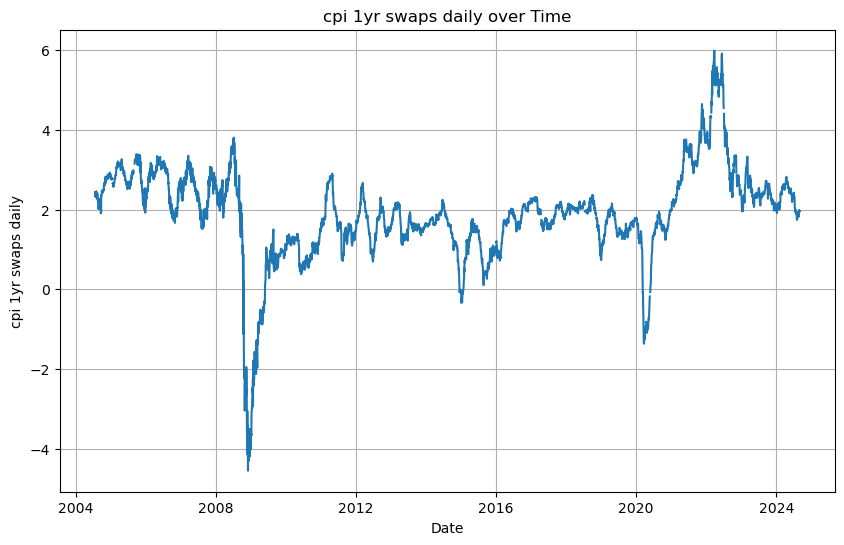

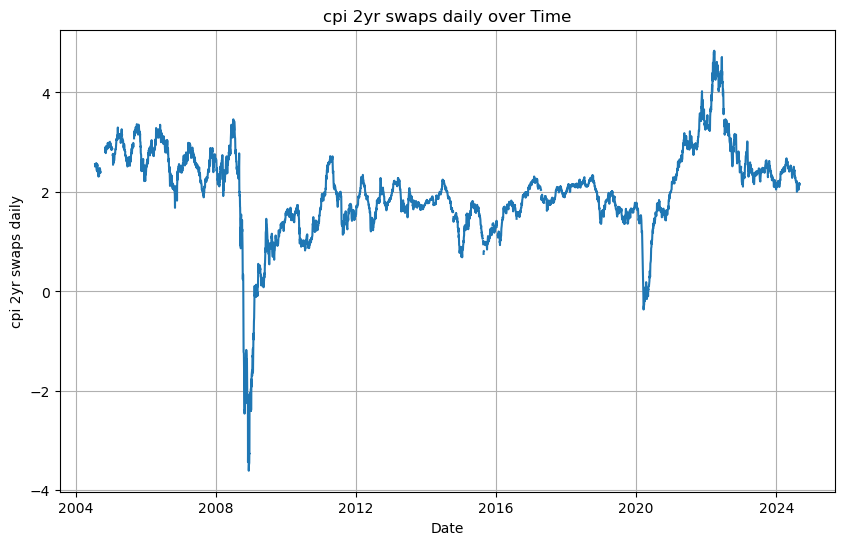

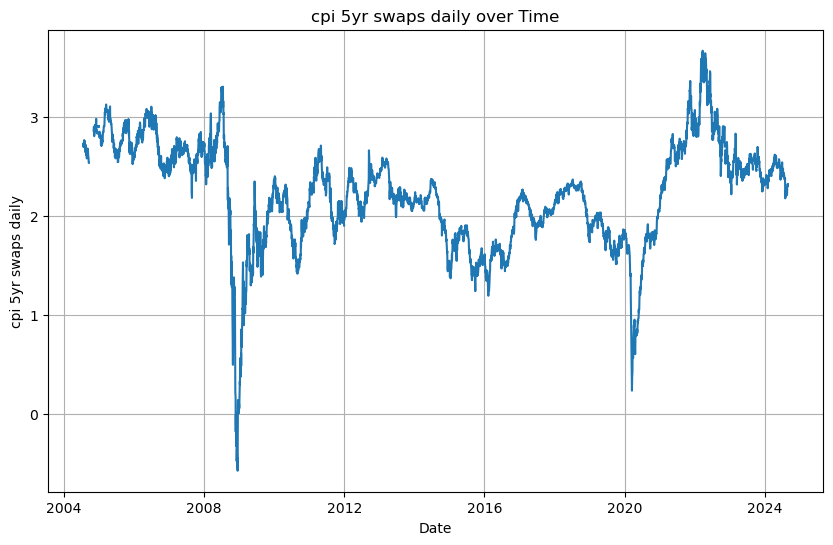

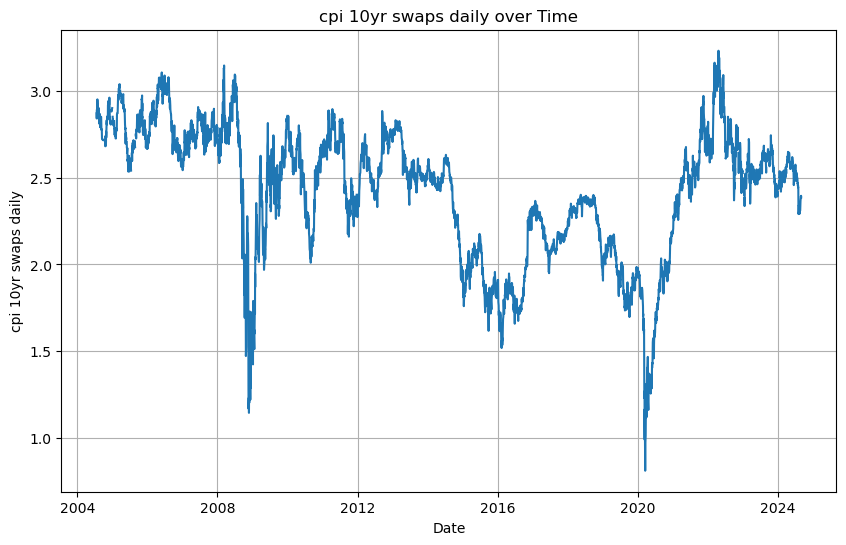

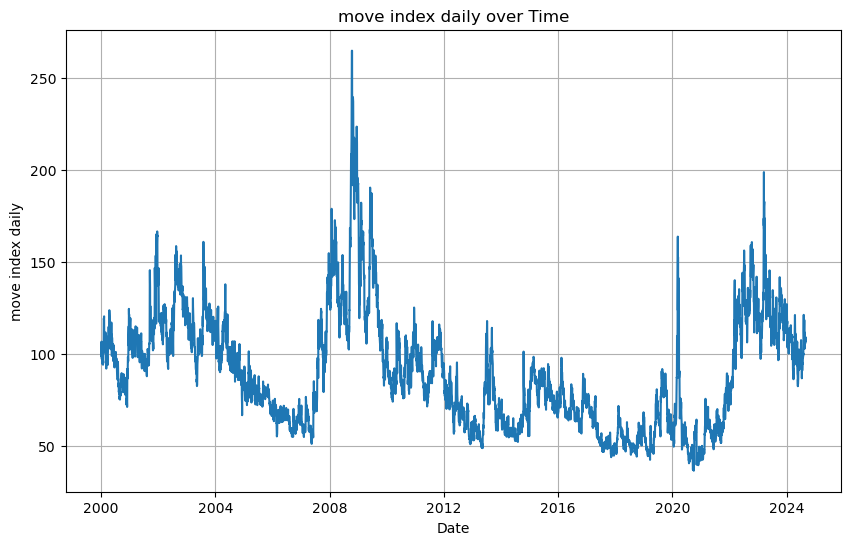

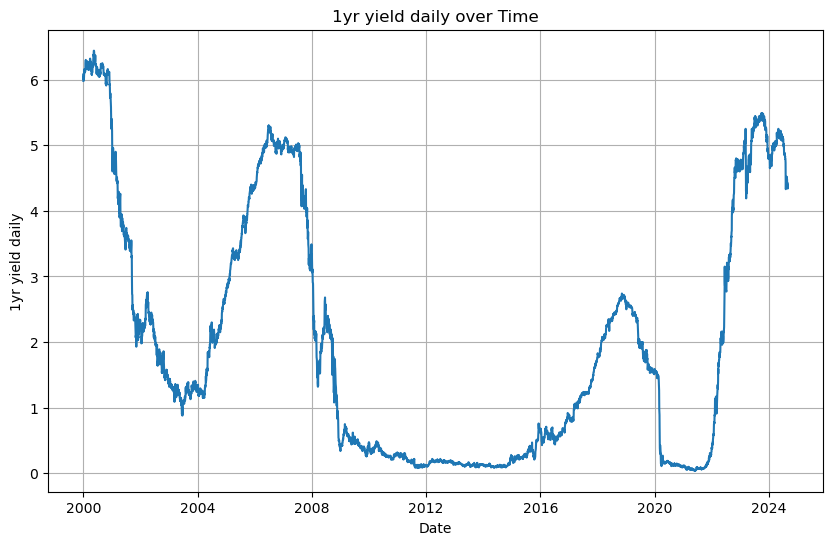

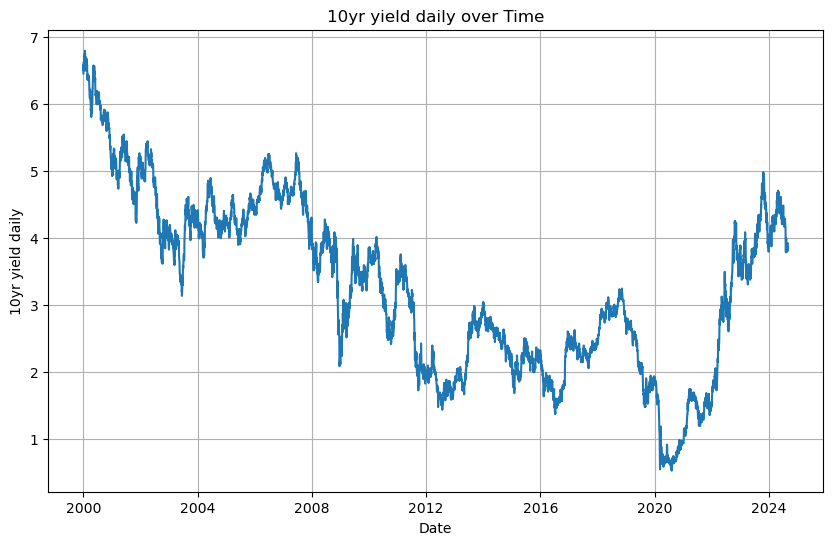

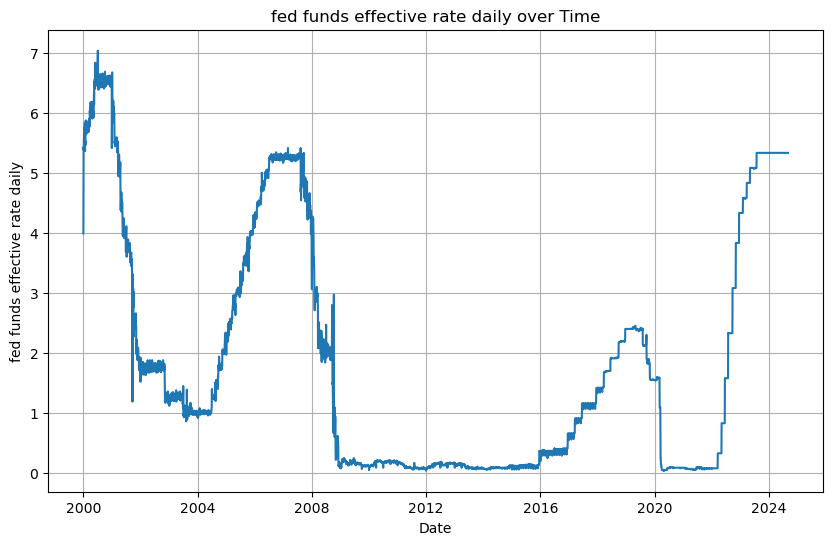

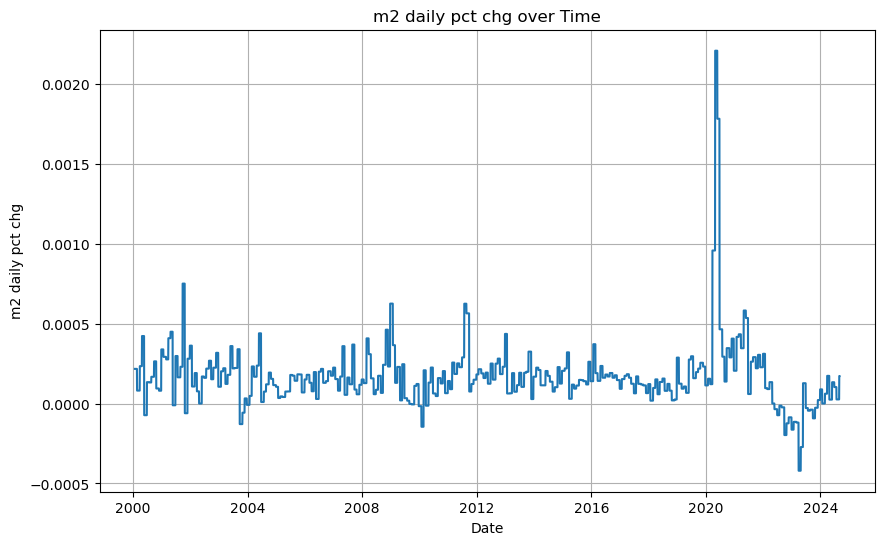

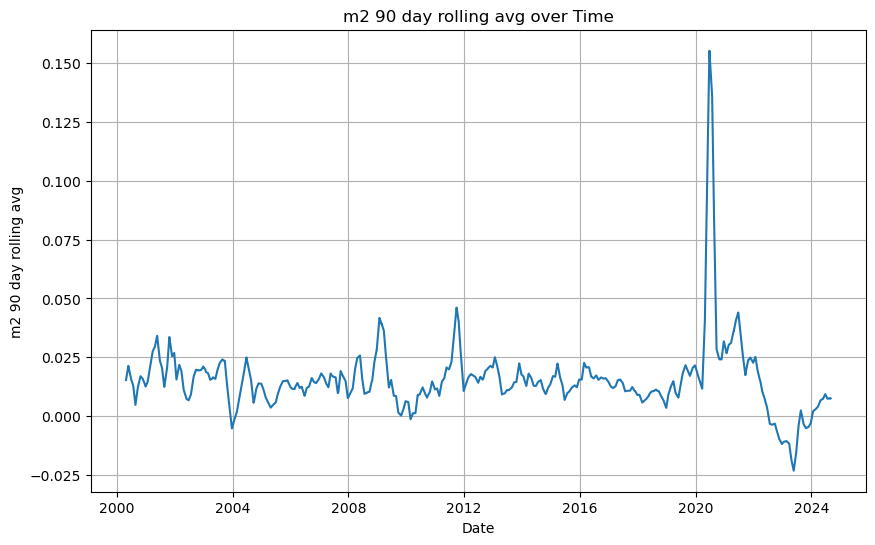

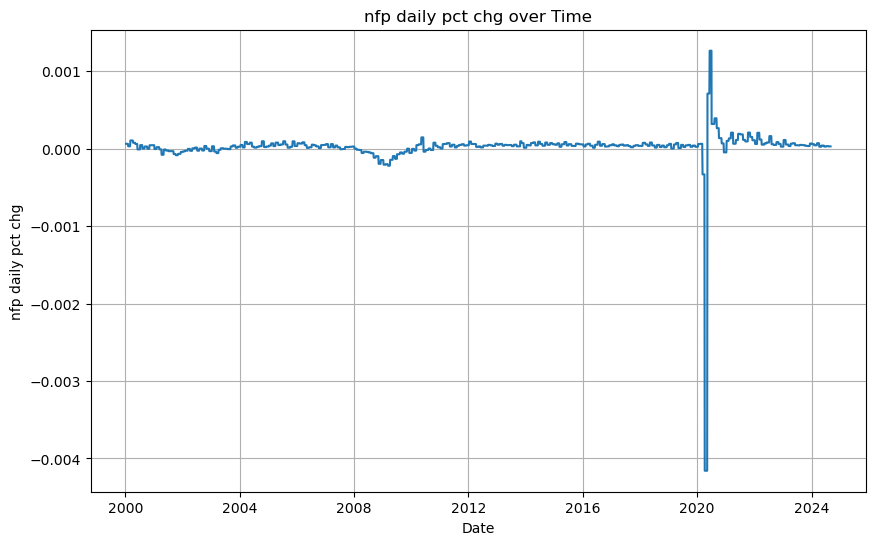

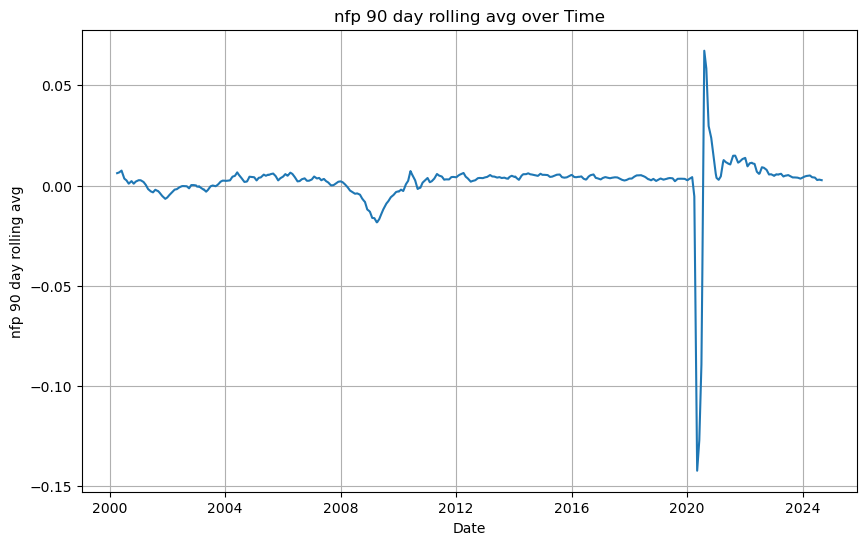

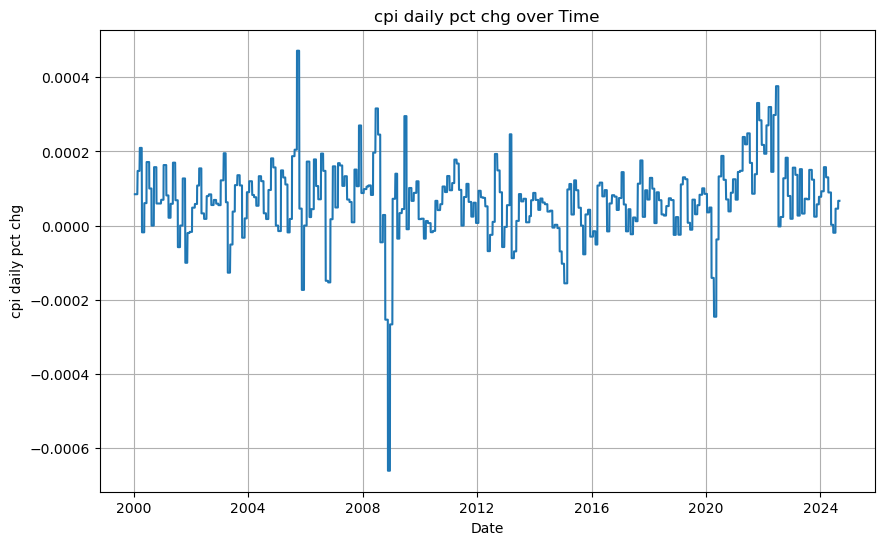

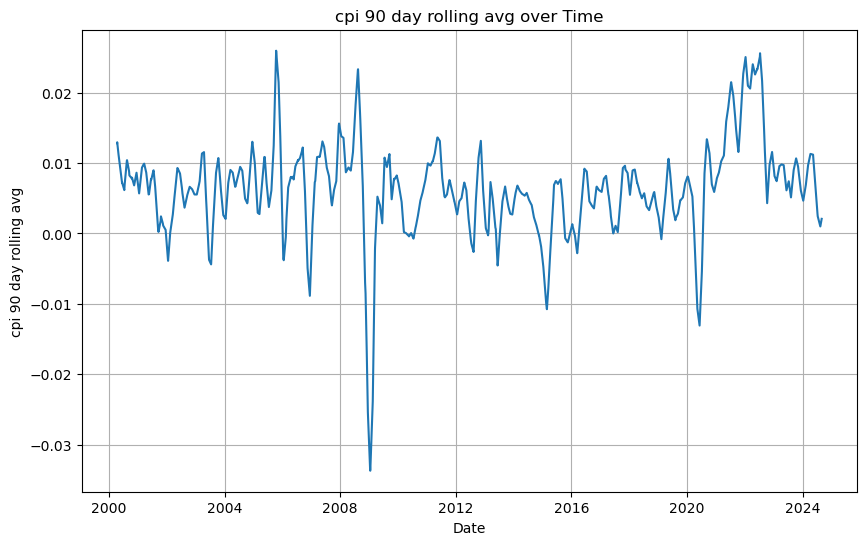

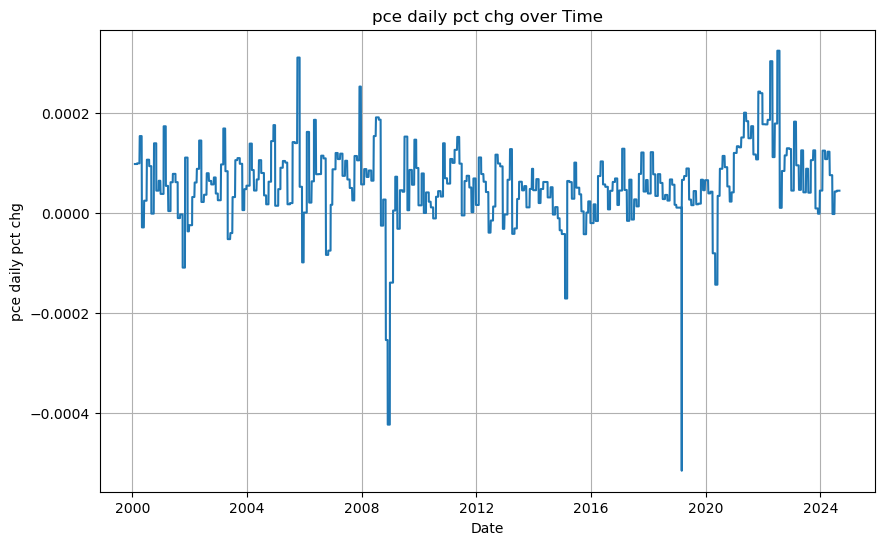

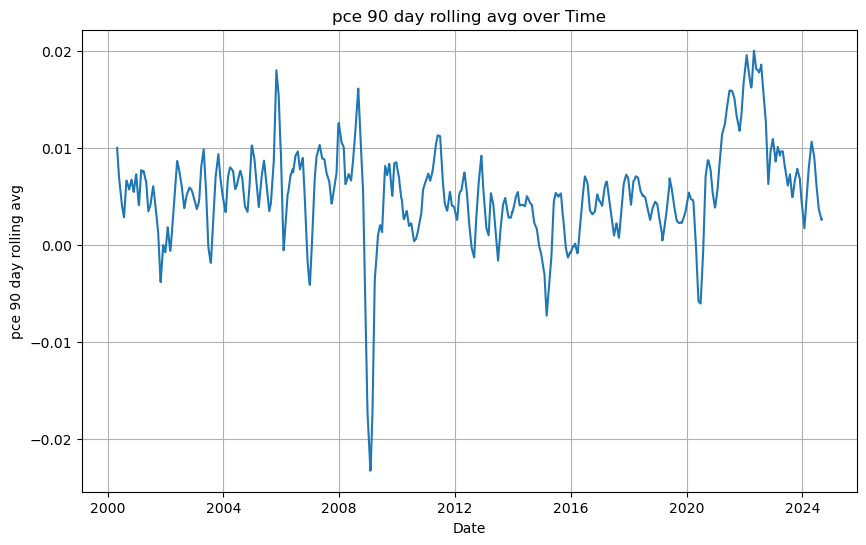

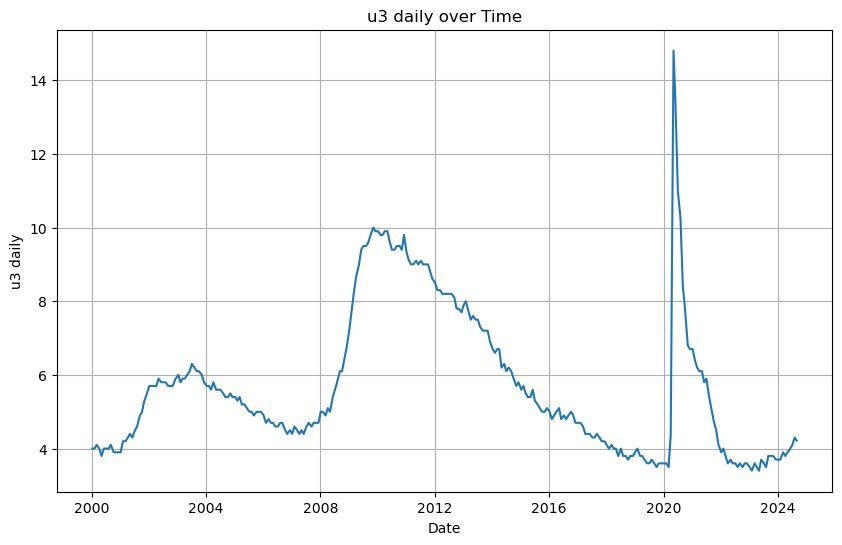

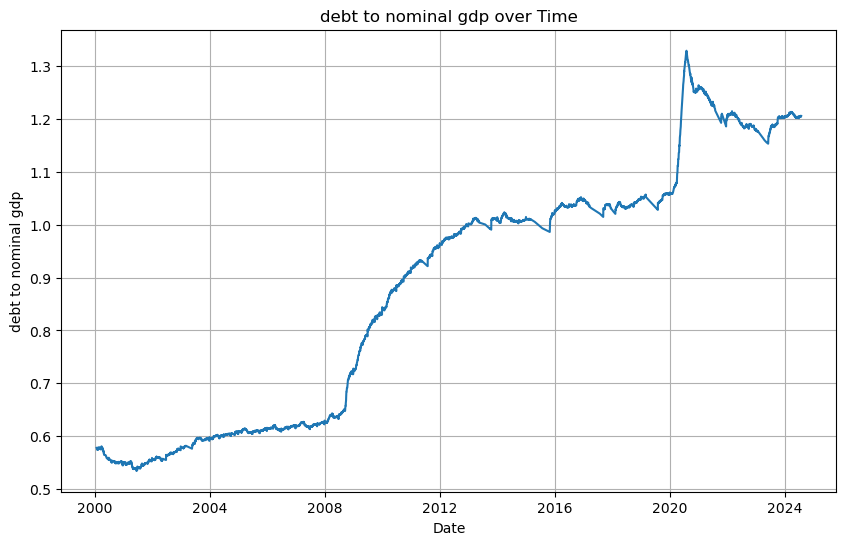

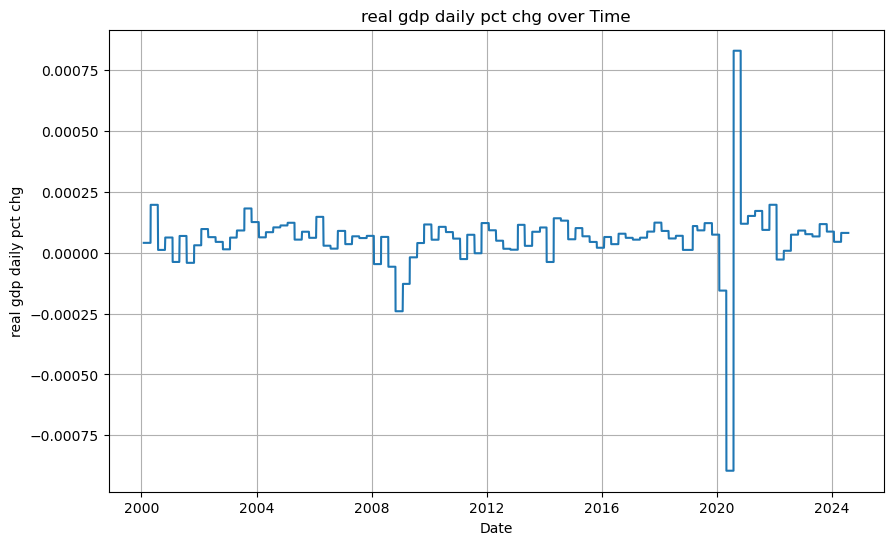

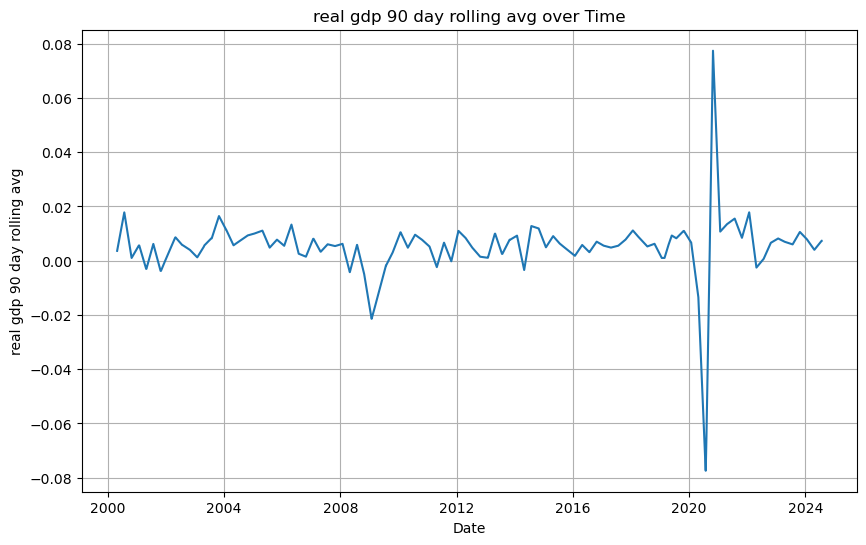

In [271]:
# Preliminary visualization of data before going further

for col in df_macro_final.columns:
    if col != 'date':
        plt.figure(figsize=(10, 6))
        plt.plot(df_macro_final['date'], df_macro_final[col])
        plt.title(f'{col} over Time')
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.grid(True)
        plt.show()

In [277]:
# Cleaning up the final missing values, and shortening the period to keep all the data

df_macro_final = df_macro_final[26:5172].reset_index(drop=True)
cpi_swap_cols = ['cpi 1yr swaps daily', 'cpi 2yr swaps daily',
                 'cpi 5yr swaps daily', 'cpi 10yr swaps daily']
for col in cpi_swap_cols:
    df_macro_final[col] = pd.to_numeric(df_macro_final[col], errors='coerce')
df_macro_final[cpi_swap_cols] = df_macro_final[cpi_swap_cols].interpolate(method='linear')
df_macro_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5146 entries, 0 to 5145
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            5146 non-null   datetime64[ns]
 1   cpi 1yr swaps daily             5146 non-null   float64       
 2   cpi 2yr swaps daily             5146 non-null   float64       
 3   cpi 5yr swaps daily             5146 non-null   float64       
 4   cpi 10yr swaps daily            5146 non-null   float64       
 5   move index daily                5146 non-null   float64       
 6   1yr yield daily                 5146 non-null   float64       
 7   10yr yield daily                5146 non-null   float64       
 8   fed funds effective rate daily  5146 non-null   float64       
 9   m2 daily pct chg                5146 non-null   float64       
 10  m2 90 day rolling avg           5146 non-null   float64       
 11  nfp 

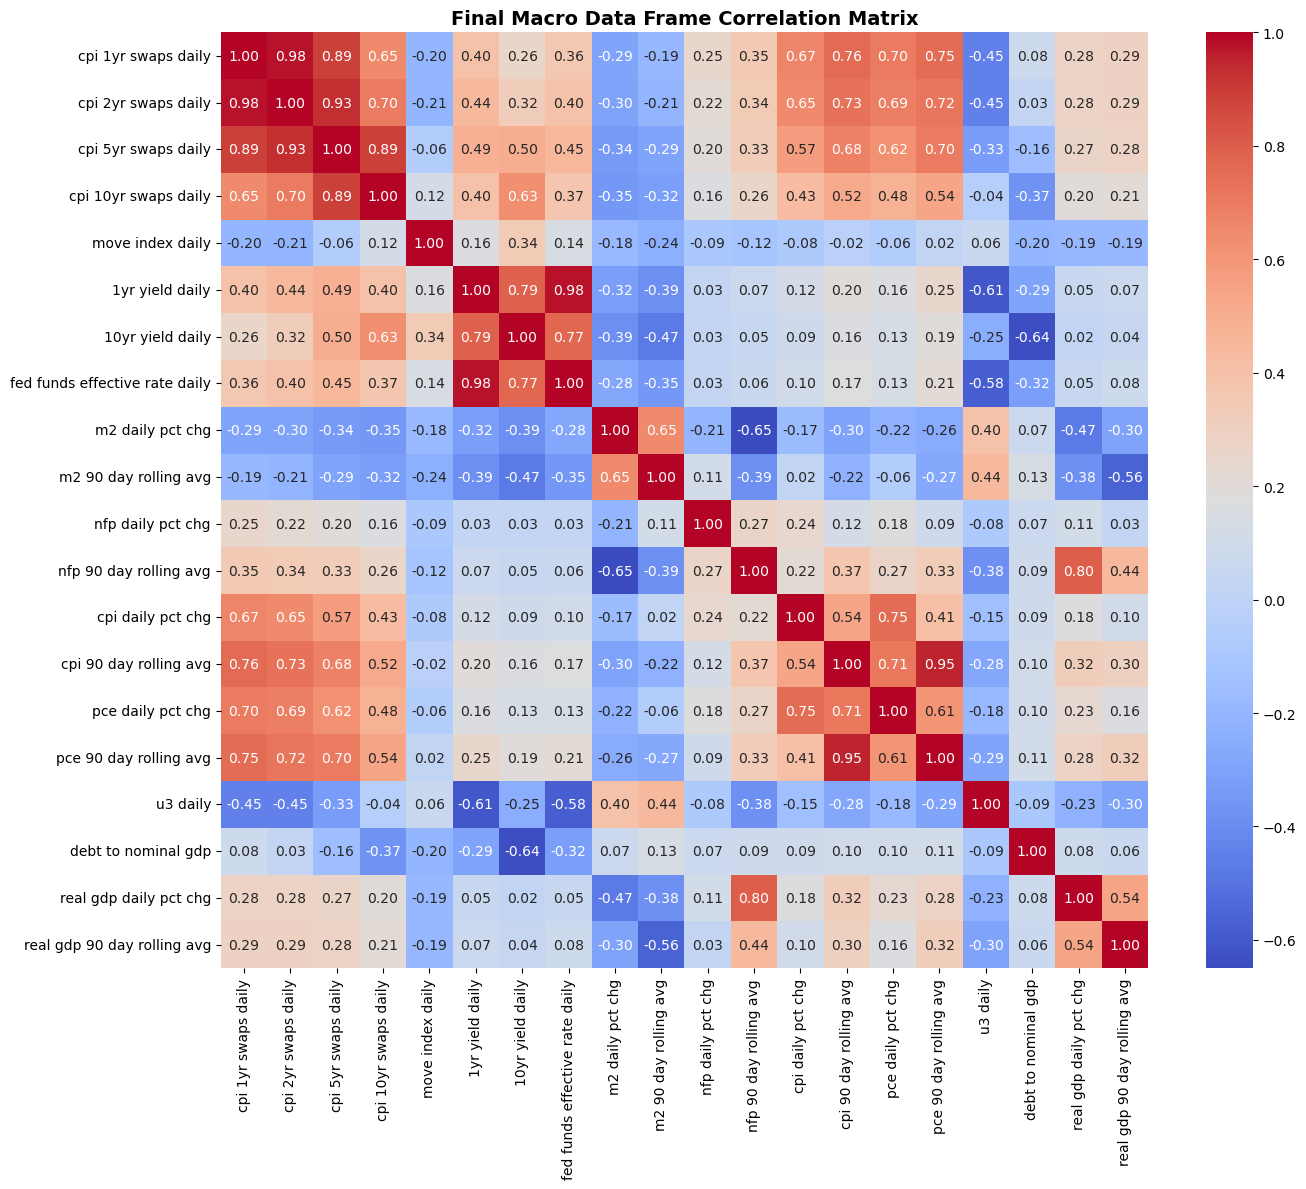

In [279]:
# Correlation Matrix without 1YR Yield Shifted

plt.figure(figsize=(14, 12))

sns.heatmap(df_macro_final.drop(columns='date').corr().round(2), annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Final Macro Data Frame Correlation Matrix", fontsize=14, fontweight='bold')

plt.tight_layout()
#plt.savefig('/Users/henrycosentino/Desktop/Python/Projects/Yield Curve/Correlation Final Macro Data Frame.png', dpi=300)
plt.show()